# ***字符语言模型***

# 0. 要解决的问题

① 欢迎来到恐龙大陆！

② 6500万年前，恐龙就已经存在，并且在该作业下它们又回来了。

③ 假设你负责一项特殊任务，领先的生物学研究人员正在创造新的恐龙品种，并计划将它们带入地球，而你的工作就是为这些新恐龙起名字。

④ 如果恐龙不喜欢它的名字，它可能会变得疯狂，所以需要明智地选择！

① 幸运的是，你掌握了深度学习的一些知识，你将使用它来节省时间。

② 你的助手已收集了他们可以找到的所有恐龙名称的列表，并将其编译到此dataset中。

③ 要创建新的恐龙名称，你将构建一个字符语言模型来生成新名称。

④ 你的算法将学习不同的名称模式，并随机生成新名称。

⑤ 希望该算法可以使你和你的团队免受恐龙的愤怒！

⑥ 完成此作业，你将学习：

 - 如何存储文本数据以供RNN使用
 - 如何在每个时间步采样预测并将其传递给下一个RNN单元以合成数据
 - 如何建立一个字符的文本生成循环神经网络
 - 为什么梯度裁剪很重要
 
⑦ 我们将从加载rnn_utils中为你提供的一些函数开始。

⑧ 具体来说，你可以访问诸如rnn_forward和rnn_backward之类的函数，这些函数与你在上一个作业中实现的函数等效。

# 1. 导入库

In [2]:
import numpy as np
import random
import time
from utils import *

# 2. 数据集和预处理

① 运行以下单元格以读取包含恐龙名称的数据集，创建唯一字符列表（例如a-z），并计算数据集和词汇量。

In [4]:
# 获取名称
data = open("dinos.txt", "r").read()

# 转化为小写字符
data = data.lower()

# 转化为无序且不重复的元素列表
chars = list(set(data))

# 获取大小信息
data_size, vocab_size = len(data), len(chars)

print(chars)
print("共计有%d个字符，唯一字符有%d个"%(data_size,vocab_size))

['j', 'n', 'm', 'c', 'q', 'i', 'a', 'v', 'l', 'f', 'z', 'y', 'w', 't', 'k', 'd', 'r', 'b', 's', 'p', 'x', 'e', 'g', 'u', 'o', '\n', 'h']
共计有19909个字符，唯一字符有27个


② 这些字符是a-z（26个字符）加上“\n”（换行符），在此作业中，其作用类似于我们前面说的$<EOS>$（句子结尾）标记，仅在此处表示恐龙名称的结尾，而不是句子的结尾。

③ 在下面的单元格中，我们创建一个python字典（即哈希表），以将每个字符映射为0-26之间的索引。

④ 我们还创建了第二个python字典，该字典将每个索引映射回对应的字符。

⑤ 这将帮助你找出softmax层的概率分布输出中哪个索引对应于哪个字符。

⑥ 下面的`char_to_ix`和`ix_to_char`是python字典。

In [5]:
char_to_ix = {ch:i for i, ch in enumerate(sorted(chars))}
ix_to_char = {i:ch for i, ch in enumerate(sorted(chars))}

print(char_to_ix)
print(ix_to_char)

{'\n': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '\n', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


# 3. 构建模型模块

① 你的模型将具有以下结构：

 1. 初始化参数
 2. 运行优化循环
   - 正向传播以计算损失函数
   - 反向传播以计算相对于损失函数的梯度
   - 剪裁梯度以避免梯度爆炸
   - 使用梯度下降方法更新参数。
 3. 返回学习的参数

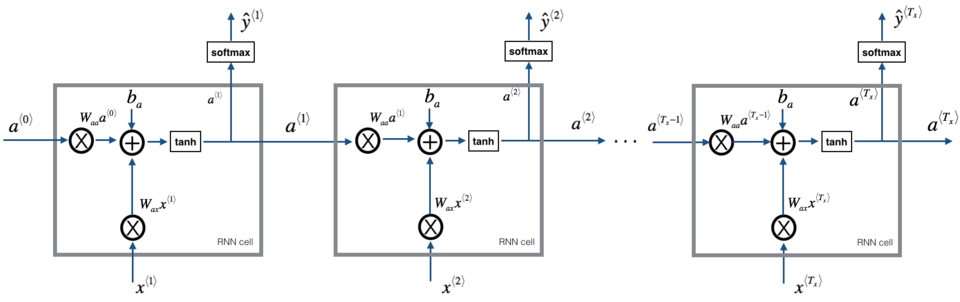

<center>图1：循环神经网络</center>

② 类似于你在上一个笔记“手把手实现循环神经网络”中构建的内容。

 - 在每个时间步，RNN都会根据给定的先前字符来预测下一个字符。
 - 数据集$X = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$是训练集中的字符列表，而$Y = (y^{\langle 1 \rangle}, y^{\langle 2 \rangle}, ..., y^{\langle T_x \rangle})$使得每个时间步，我们有$y^{\langle t \rangle} = x^{\langle t+1 \rangle}$。

③ 在这一部分中，你将构建整个模型的两个重要模块：

 - 梯度裁剪：避免梯度爆炸
 - 采样：一种用于生成字符的技术
 
④ 然后，你将应用这两个函数来构建模型。

## 3.1 裁剪梯度

① 在本节中，你将实现在优化循环中调用的clip函数。

② 回想一下，你的总体循环结构通常由正向传播，损失计算，反向传播和参数更新组成。

③ 在更新参数之前，你将在需要时执行梯度裁剪，以确保你的梯度不会“爆炸”，这意味着要采用很大的值。

④ 在下面的练习中，你将实现一个函数clip，该函数接收梯度字典，并在需要时返回裁剪后的梯度。

⑤ 梯度裁剪有多种方法。我们将使用简单的按元素裁剪程序，其中将梯度向量的每个元素裁剪为位于范围[-N，N]之间。

⑥ 通常，你将提供一个maxValue（例如10）。在此示例中，如果梯度向量的任何分量大于10，则将其设置为10；并且如果梯度向量的任何分量小于-10，则将其设置为-10。如果介于-10和10之间，则将其保留。

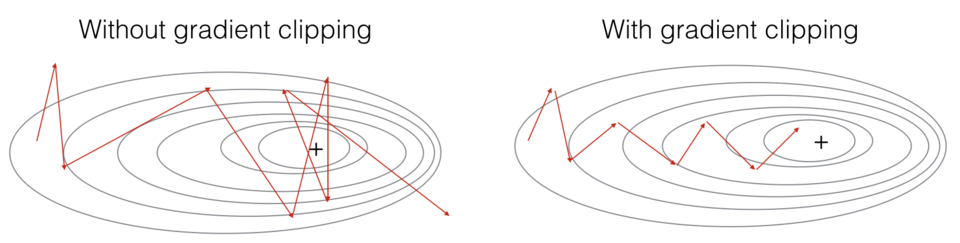

<center>图2：在网络遇到轻微的“梯度爆炸”的情况下，使用与不使用梯度裁剪的梯度下降对比</center>

⑦ 练习：实现以下函数以返回字典gradients的裁剪梯度。

 - 你的函数接受最大阈值，并返回裁剪后的梯度。

In [6]:
def clip(gradients, maxValue):
    """
    使用maxValue来修剪梯度
    
    参数：
        gradients -- 字典类型，包含了以下参数："dWaa", "dWax", "dWya", "db", "dby"
        maxValue -- 阈值，把梯度值限制在[-maxValue, maxValue]内
        
    返回：
        gradients -- 修剪后的梯度
    """
    # 获取参数
    dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'], gradients['db'], gradients['dby']
    
    # 梯度修剪
    for gradient in [dWaa, dWax, dWya, db, dby]:
        np.clip(gradient, -maxValue, maxValue, out=gradient)

    gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "db": db, "dby": dby}
    
    return gradients

In [7]:
np.random.seed(3)
dWax = np.random.randn(5,3)*10
dWaa = np.random.randn(5,5)*10
dWya = np.random.randn(2,5)*10
db = np.random.randn(5,1)*10
dby = np.random.randn(2,1)*10
gradients = {"dWax": dWax, "dWaa": dWaa, "dWya": dWya, "db": db, "dby": dby}
gradients = clip(gradients, 10)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWya\"][1][2] =", gradients["dWya"][1][2])
print("gradients[\"db\"][4] =", gradients["db"][4])
print("gradients[\"dby\"][1] =", gradients["dby"][1])

gradients["dWaa"][1][2] = 10.0
gradients["dWax"][3][1] = -10.0
gradients["dWya"][1][2] = 0.2971381536101662
gradients["db"][4] = [10.]
gradients["dby"][1] = [8.45833407]


## 3.2 采样

① 现在假设你的模型已经训练好。你想生成新文本（字符）。下图说明了生成过程：

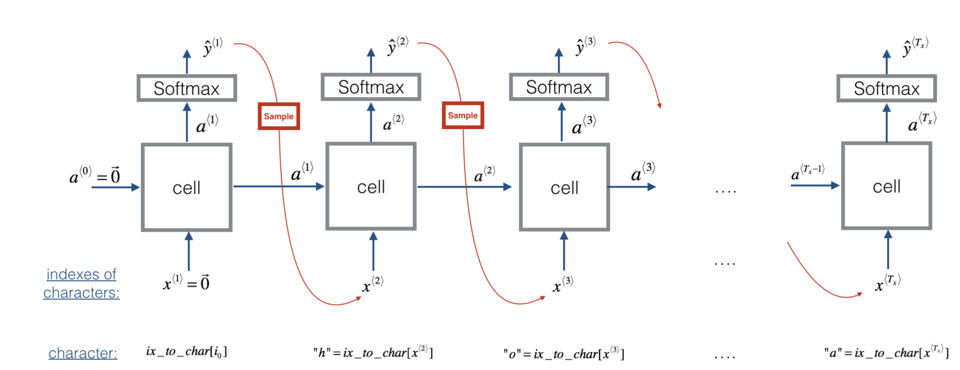

<center>图3：在此图中，我们假设模型已经训练好</center>

② 我们在第一步中传入$x^{\langle 1\rangle} = \vec{0}$，然后让网络一次采样一个字符。

③ 练习：实现以下的sample函数来采样字母。你需要执行4个步骤：

 - 步骤1：将第一个"dummy"输入$x^{\langle 1 \rangle} = \vec{0}$（零向量）传递给网络。这是我们生成任意字母之前的默认输入。我们还设置$a^{\langle 0 \rangle} = \vec{0}$。
 - 步骤2：执行向正向传播的步骤，即可获得$a^{\langle 1 \rangle}$and$\hat{y}^{\langle 1 \rangle}$ 。以下是等式：
$$a^{\langle t+1 \rangle} = \tanh(W_{ax}  x^{\langle t \rangle } + W_{aa} a^{\langle t \rangle } + b)\tag{1}$$
$$z^{\langle t + 1 \rangle } = W_{ya}  a^{\langle t + 1 \rangle } + b_y \tag{2}$$
$$\hat{y}^{\langle t+1 \rangle } = softmax(z^{\langle t + 1 \rangle })\tag{3}$$
   - 注意：$\hat{y}^{\langle t+1 \rangle }$是一个（softmax）概率向量（其条目在0到1之间且总和为1）。$\hat{y}^{\langle t+1 \rangle}_i$表示由"i"索引的字符是下一个字符的概率。我们提供了一个softmax（）函数供你使用。
 - 步骤3：执行采样：根据$\hat{y}^{\langle t+1 \rangle }$
指定的概率分布，选择下一个字符的索引。这意味着，如果$\hat{y}^{\langle t+1 \rangle }_i = 0.16$，你将以16％的概率选择索引"i"。要实现它，你可以使用`np.random.choice`。
   - 以下是一个使用`np.random.choice()`的例子：

```python
np.random.seed(0)
p = np.array([0.1, 0.0, 0.7, 0.2])
index = np.random.choice([0, 1, 2, 3], p = p.ravel())
```

     - 这意味着你将根据分布选择index：$P(index = 0) = 0.1, P(index = 1) = 0.0, P(index = 2) = 0.7, P(index = 3) = 0.2$

 - 步骤4：要在`sample()`中实现的最后一步是覆盖变量x，该变量当前存储$x^{\langle t \rangle }$，其值为$x^{\langle t + 1 \rangle }$。通过创建与预测字符相对应的独热向量以表示$x^{\langle t + 1 \rangle }$。然后，你将在步骤1中前向传播$x^{\langle t + 1 \rangle }$，并继续重复此过程，直到获得“\n”字符，表明你已经到达恐龙名称的末尾。

In [8]:
def sample(parameters, char_to_is, seed):
    """
    根据RNN输出的概率分布序列对字符序列进行采样
    
    参数：
        parameters -- 包含了Waa, Wax, Wya, by, b的字典
        char_to_ix -- 字符映射到索引的字典
        seed -- 随机种子
        
    返回：
        indices -- 包含采样字符索引的长度为n的列表。
    """
    
    # 从parameters 中获取参数
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    vocab_size = by.shape[0]
    n_a = Waa.shape[1]
    
    # 步骤1 
    ## 创建独热向量x
    x = np.zeros((vocab_size,1))
    
    ## 使用0初始化a_prev
    a_prev = np.zeros((n_a,1))
    
    # 创建索引的空列表，这是包含要生成的字符的索引的列表。
    indices = []
    
    # IDX是检测换行符的标志，我们将其初始化为-1。
    idx = -1
    
    # 循环遍历时间步骤t。在每个时间步中，从概率分布中抽取一个字符，
    # 并将其索引附加到“indices”上，如果我们达到50个字符，
    #（我们应该不太可能有一个训练好的模型），我们将停止循环，这有助于调试并防止进入无限循环
    counter = 0
    newline_character = char_to_ix["\n"]
    
    while (idx != newline_character and counter < 50):
        # 步骤2：使用公式1、2、3进行前向传播
        a = np.tanh(np.dot(Wax, x) + np.dot(Waa, a_prev) + b)
        z = np.dot(Wya, a) + by
        y = softmax(z)
        
        # 设定随机种子
        np.random.seed(counter + seed)
        
        # 步骤3：从概率分布y中抽取词汇表中字符的索引
        idx = np.random.choice(list(range(vocab_size)), p=y.ravel())
        
        # 添加到索引中
        indices.append(idx)
        
        # 步骤4:将输入字符重写为与采样索引对应的字符。
        x = np.zeros((vocab_size,1))
        x[idx] = 1
        
        # 更新a_prev为a
        a_prev = a 
        
        # 累加器
        seed += 1
        counter +=1
    
    if(counter == 50):
        indices.append(char_to_ix["\n"])
    
    return indices

In [9]:
np.random.seed(2)
_, n_a = 20, 100
Wax, Waa, Wya = np.random.randn(n_a, vocab_size), np.random.randn(n_a, n_a), np.random.randn(vocab_size, n_a)
b, by = np.random.randn(n_a, 1), np.random.randn(vocab_size, 1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}


indices = sample(parameters, char_to_ix, 0)
print("Sampling:")
print("list of sampled indices:", indices)
print("list of sampled characters:", [ix_to_char[i] for i in indices])

Sampling:
list of sampled indices: [12, 17, 24, 14, 13, 9, 10, 22, 24, 6, 13, 11, 12, 6, 21, 15, 21, 14, 3, 2, 1, 21, 18, 24, 7, 25, 6, 25, 18, 10, 16, 2, 3, 8, 15, 12, 11, 7, 1, 12, 10, 2, 7, 7, 11, 17, 6, 12, 11, 17, 0]
list of sampled characters: ['l', 'q', 'x', 'n', 'm', 'i', 'j', 'v', 'x', 'f', 'm', 'k', 'l', 'f', 'u', 'o', 'u', 'n', 'c', 'b', 'a', 'u', 'r', 'x', 'g', 'y', 'f', 'y', 'r', 'j', 'p', 'b', 'c', 'h', 'o', 'l', 'k', 'g', 'a', 'l', 'j', 'b', 'g', 'g', 'k', 'q', 'f', 'l', 'k', 'q', '\n']


# 4. 构建语言模型

① 现在是时候建立用于文字生成的字符语言模型了。

## 4.1 梯度下降

① 在本部分中，你将实现一个函数，该函数执行随机梯度下降的一个步骤（梯度裁剪）。

② 你将一次查看一个训练示例，因此优化算法为随机梯度下降。

③ 提醒一下，以下是RNN常见的优化循环的步骤：

 1. 通过RNN正向传播以计算损失
 2. 随时间反向传播以计算相对于参数的损失梯度
 3. 必要时裁剪梯度
 4. 使用梯度下降更新参数

④ 练习：实现此优化过程（随机梯度下降的一个步骤）。

⑤ 我们为你提供了以下函数：

In [ ]:
'''
# 示例，请勿执行。
def rnn_forward(X, Y, a_prev, parameters):
    """
    通过RNN进行前向传播，计算交叉熵损失。

    它返回损失的值以及存储在反向传播中使用的“缓存”值。
    """
    ....
    return loss, cache
    
def rnn_backward(X, Y, parameters, cache):
    """ 
    通过时间进行反向传播，计算相对于参数的梯度损失。它还返回所有隐藏的状态
    """
    ...
    return gradients, a

def update_parameters(parameters, gradients, learning_rate):
    """
    Updates parameters using the Gradient Descent Update Rule
    """
    ...
    return parameters
'''

In [10]:
def optimize(X, Y, a_prev, parameters, learning_rate = 0.01):
    """
    执行训练模型的单步优化。
    
    参数：
        X -- 整数列表，其中每个整数映射到词汇表中的字符。
        Y -- 整数列表，与X完全相同，但向左移动了一个索引。
        a_prev -- 上一个隐藏状态
        parameters -- 字典，包含了以下参数：
                        Wax -- 权重矩阵乘以输入，维度为(n_a, n_x)
                        Waa -- 权重矩阵乘以隐藏状态，维度为(n_a, n_a)
                        Wya -- 隐藏状态与输出相关的权重矩阵，维度为(n_y, n_a)
                        b -- 偏置，维度为(n_a, 1)
                        by -- 隐藏状态与输出相关的权重偏置，维度为(n_y, 1)
        learning_rate -- 模型学习的速率
    
    返回：
        loss -- 损失函数的值（交叉熵损失）
        gradients -- 字典，包含了以下参数：
                        dWax -- 输入到隐藏的权值的梯度，维度为(n_a, n_x)
                        dWaa -- 隐藏到隐藏的权值的梯度，维度为(n_a, n_a)
                        dWya -- 隐藏到输出的权值的梯度，维度为(n_y, n_a)
                        db -- 偏置的梯度，维度为(n_a, 1)
                        dby -- 输出偏置向量的梯度，维度为(n_y, 1)
        a[len(X)-1] -- 最后的隐藏状态，维度为(n_a, 1)
    """
    
    # 前向传播
    loss, cache = rnn_forward(X, Y, a_prev, parameters)
    
    # 反向传播
    gradients, a = rnn_backward(X, Y, parameters, cache)
    
    # 梯度修剪，[-5 , 5]
    gradients = clip(gradients,5)
    
    # 更新参数
    parameters = update_parameters(parameters,gradients,learning_rate)
    
    return loss, gradients, a[len(X)-1]

In [11]:
np.random.seed(1)
vocab_size, n_a = 27, 100
a_prev = np.random.randn(n_a, 1)
Wax, Waa, Wya = np.random.randn(n_a, vocab_size), np.random.randn(n_a, n_a), np.random.randn(vocab_size, n_a)
b, by = np.random.randn(n_a, 1), np.random.randn(vocab_size, 1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}
X = [12,3,5,11,22,3]
Y = [4,14,11,22,25, 26]

loss, gradients, a_last = optimize(X, Y, a_prev, parameters, learning_rate = 0.01)
print("Loss =", loss)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("np.argmax(gradients[\"dWax\"]) =", np.argmax(gradients["dWax"]))
print("gradients[\"dWya\"][1][2] =", gradients["dWya"][1][2])
print("gradients[\"db\"][4] =", gradients["db"][4])
print("gradients[\"dby\"][1] =", gradients["dby"][1])
print("a_last[4] =", a_last[4])

Loss = 126.50397572165383
gradients["dWaa"][1][2] = 0.19470931534715546
np.argmax(gradients["dWax"]) = 93
gradients["dWya"][1][2] = -0.007773876032002889
gradients["db"][4] = [-0.06809825]
gradients["dby"][1] = [0.01538192]
a_last[4] = [-1.]


## 4.2 训练模型

① 给定恐龙名称数据集，我们将数据集的每一行（一个名称）用作一个训练示例。

② 每100步随机梯度下降，你将抽样10个随机选择的名称，以查看算法的运行情况。

③ 请记住要对数据集进行混洗，以便随机梯度下降以随机顺序访问示例。

④ 按照说明进行操作并实现`model()`。

⑤ 当`examples [index]`包含一个恐龙名称（字符串）时，创建示例（X，Y），可以使用以下方法：

```python
        index = j % len(examples)
        X = [None] + [char_to_ix[ch] for ch in examples[index]] 
        Y = X[1:] + [char_to_ix["\n"]]
```
 
⑥ 注意，我们使用：`index= j % len(examples)`，其中j = 1....num_iterations，以确保`examples [index]`始终是有效的语句（index小于`len(examples)`）。

⑦ X的第一个条目为None将被rnn_forward()解释为设置$x^{\langle 0 \rangle} = \vec{0}$。

⑧ 此外，这确保了Y等于X，但向左移动了一步，并附加了“\n”以表示恐龙名称的结尾。

In [18]:
def model(data, ix_to_char, char_to_ix, num_iterations=35000, 
          n_a=50, dino_names=7,vocab_size=27):
    """
    训练模型并生成恐龙名字
    
    参数：
        data -- 语料库
        ix_to_char -- 索引映射字符字典
        char_to_ix -- 字符映射索引字典
        num_iterations -- 迭代次数
        n_a -- RNN单元数量
        dino_names -- 每次迭代中采样的数量
        vocab_size -- 在文本中的唯一字符的数量
    
    返回：
        parameters -- 学习后了的参数
    """
    
    # 从vocab_size中获取n_x、n_y
    n_x, n_y = vocab_size, vocab_size
    
    # 初始化参数
    parameters = initialize_parameters(n_a, n_x, n_y)
    
    # 初始化损失
    loss = get_initial_loss(vocab_size, dino_names)
    
    # 构建恐龙名称列表
    with open("dinos.txt") as f:
        examples = f.readlines()
    examples = [x.lower().strip() for x in examples]
    
    # 打乱全部的恐龙名称
    np.random.seed(0)
    np.random.shuffle(examples)
    
    # 初始化LSTM隐藏状态
    a_prev = np.zeros((n_a,1))
    
    # 循环
    for j in range(num_iterations):
        # 定义一个训练样本
        index = j % len(examples)
        X = [None] + [char_to_ix[ch] for ch in examples[index]] 
        Y = X[1:] + [char_to_ix["\n"]]
        
        # 执行单步优化：前向传播 -> 反向传播 -> 梯度修剪 -> 更新参数
        # 选择学习率为0.01
        curr_loss, gradients, a_prev = optimize(X, Y, a_prev, parameters)
        
        # 使用延迟来保持损失平滑,这是为了加速训练。
        loss = smooth(loss, curr_loss)
        
        # 每2000次迭代，通过sample()生成“\n”字符，检查模型是否学习正确
        if j % 2000 == 0:
            print("第" + str(j+1) + "次迭代，损失值为：" + str(loss))
            
            seed = 0
            for name in range(dino_names):
                # 采样
                sampled_indices = sample(parameters, char_to_ix, seed)
                print_sample(sampled_indices, ix_to_char)
                
                # 为了得到相同的效果，随机种子+1
                seed += 1
            
            print("\n")
    return parameters

① 运行以下单元格，你应该观察到模型在第一次迭代时输出看似随机的字符。

② 经过数千次迭代后，你的模型应该学会生成看起来合理的名称。

In [19]:
parameters = model(data, ix_to_char, char_to_ix)

第1次迭代，损失值为：23.087336085484605
Nkzxwtdmfqoeyhsqwasjkjvu
Kneb
Kzxwtdmfqoeyhsqwasjkjvu
Neb
Zxwtdmfqoeyhsqwasjkjvu
Eb
Xwtdmfqoeyhsqwasjkjvu


第2001次迭代，损失值为：27.884160491415777
Liusskeomnolxeros
Hmdaairus
Hytroligoraurus
Lecalosapaus
Xusicikoraurus
Abalpsamantisaurus
Tpraneronxeros


第4001次迭代，损失值为：25.901814893353023
Mivrosaurus
Inee
Ivtroplisaurus
Mbaaisaurus
Wusichisaurus
Cabaselachus
Toraperlethosdarenitochusthiamamumamaon


第6001次迭代，损失值为：24.608778900832398
Onwusceomosaurus
Lieeaerosaurus
Lxussaurus
Oma
Xusteonosaurus
Eeahosaurus
Toreonosaurus


第8001次迭代，损失值为：24.070350147705284
Onxusichepriuon
Kilabersaurus
Lutrodon
Omaaerosaurus
Xutrcheps
Edaksoje
Trodiktonus


第10001次迭代，损失值为：23.844446460026578
Onyusaurus
Klecalosaurus
Lustodon
Ola
Xusodonia
Eeaeosaurus
Troceosaurus


第12001次迭代，损失值为：23.291971267936717
Onyxosaurus
Kica
Lustrepiosaurus
Olaagrraiansaurus
Yuspangosaurus
Eealosaurus
Trognesaurus


第14001次迭代，损失值为：23.38233830263197
Meutromodromurus
Inda
Iutroinatorsaurus
Maca
Yusteratoptititan
C

# 5. 结论

① 你可以看到，在训练即将结束时，你的算法已开始生成合理的恐龙名称。

② 刚开始时，它会生成随机字符，但是到最后，你会看到恐龙名字的结尾很酷。

 - 运行该算法更长时间，并调整超参数来看看是否可以获得更好的结果。

③ 我们的实现产生了一些非常酷的名称，例如“maconucon”，“marloralus”和“macingsersaurus”。

④ 你的模型还有望了解到恐龙名称往往以saurus，don，aura，tor等结尾。

⑤ 如果你的模型生成了一些不酷的名字，请不要完全怪罪模型，并非所有实际的恐龙名字听起来都很酷。（例如，dromaeosauroides是实际存在的恐龙名称，并且也在训练集中。）但是此模型应该给你提供了一组可以从中挑选的候选名字！

⑥ 该作业使用了相对较小的数据集，因此你可以在CPU上快速训练RNN。

⑦ 训练英语模型需要更大的数据集，并且通常需要更多的计算，在GPU上也要运行多个小时。

⑧ 我们使用恐龙的名字已经有一段时间了，到目前为止，我们最喜欢的名字是great, undefeatable,且fierce的：Mangosaurus!

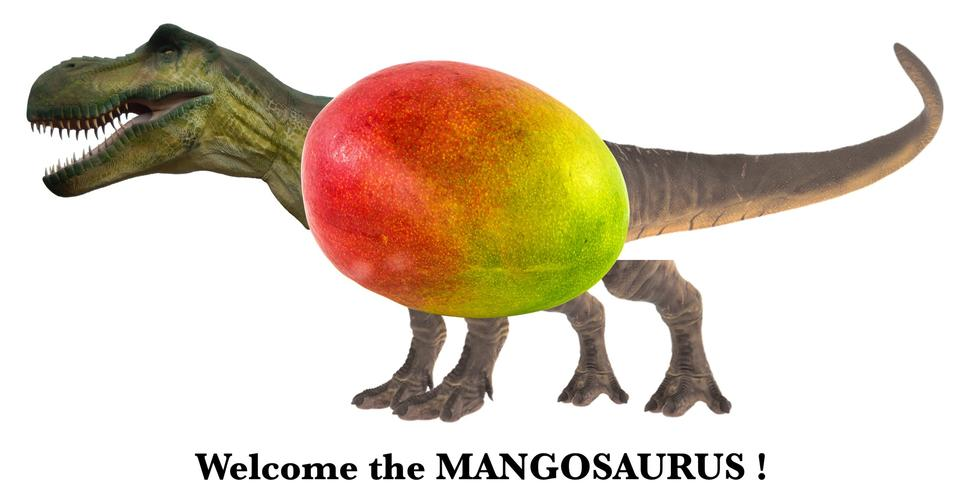

# ***诗歌生成***

# 0. 要解决的问题

① 该笔记本的其余部分是可选的，尚未评分，但我们希望你都尝试做一下，因为它非常有趣且内容丰富。

② 一个类似（但更复杂）的任务是生成莎士比亚诗歌。

③ 无需从恐龙名称的数据集中学习，而是使用莎士比亚诗歌集。

④ 使用LSTM单元，你可以学习跨文本中许多字符的长期依赖关系。

⑤ 例如，某个字符出现在序列的某个地方可能会影响序列后面的其他字符。

⑥ 这些长期依赖关系对于恐龙名称来说不太重要，因为它们的名称很短。

![](images/shakespeare.jpg)

① 让我们成为诗人！

② 我们已经用Keras实现了莎士比亚诗歌生成器。

③ 运行以下单元格以加载所需的软件包和模型。这可能需要几分钟的时间。

# 1. 导入库

In [ ]:
import h5py

# 打开 .h5 文件
file_path = 'models/model_shakespeare_kiank_350_epoch.h5'
with h5py.File(file_path, 'a') as f:
    # 查看所有的组
    print("Keys: %s" % f.keys())

    # 假设优化器权重在 'optimizer_weights' 组中
    if 'optimizer_weights' in f:
        # 打开 optimizer_weights 组
        optimizer_weights = f['optimizer_weights']

        # 打印 optimizer_weights 的内容，查看是否包含学习率参数
        print("Optimizer weights keys: %s" % optimizer_weights.keys())

        # 查找并修改学习率参数
        for key in optimizer_weights.keys():
            if 'lr' in key:
                print(f"Original learning rate: {optimizer_weights[key][()]}")
                # 修改学习率（示例：将学习率设置为 0.001）
                # optimizer_weights[key][()] = 0.001
                print(f"New learning rate: {optimizer_weights[key][()]}")

        # 如果未找到学习率参数，可以尝试打印所有数据集的名称和内容
        for key in optimizer_weights.keys():
            print(f"Dataset name: {key}, Dataset content: {optimizer_weights[key][()]}")

# 关闭文件
f.close()

In [ ]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking
from keras.layers import LSTM
from keras.utils import get_file
from keras.preprocessing.sequence import pad_sequences
from shakespeare_utils import *
import sys
import io

可能报错`Argument(s) not recognized: {'lr': 0.0010000000474974513}`

# 2. 训练一轮

① 为了节省你的时间，我们已经在莎士比亚的十四行诗"The Sonnets"诗歌集上训练了大约1000个epoch的模型。

② 让我们再训练模型完成一个新epoch，这也将花费几分钟。

In [ ]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(x, y, batch_size=128, epochs=1, callbacks=[print_callback])

# 3. 生成诗歌

① 你可以运行generate_output，这将提示你输入小于40个字符的句子。

② 这首诗将从你输入的句子开始，我们的RNN-Shakespeare将为你完成其余的部分！

③ 例如，尝试"Forsooth this maketh no sense "（不要输入引号）。

④ 根据是否在末尾加上空格，你的结果也可能会有所不同，两种方法都应尝试，也可以尝试其他输入法。

In [ ]:
# Run this cell to try with different inputs without having to re-train the model 
generate_output()

# 4. 总结对比

① RNN-Shakespeare模型与你为恐龙名称构建的模型非常相似。

② 唯一的区别是：

 - LSTM代替基本的RNN来捕获更远的依赖
 - 模型是更深的堆叠的LSTM模型（2层）
 - 使用Keras而不是python来简化代码